In [461]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler,StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [462]:
#the new clean dataframe
df2 = pd.read_csv('cleaned_data.csv', index_col=0)


In [463]:
pd.options.display.max_columns=100 # to see all columns

In [464]:
df2.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,decade,funder_cat
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,Mnyusi B,Iringa,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,False,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,0,90s,Others
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,Nyamara,Mara,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,0,10s,Others
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,0,Pangani,Majengo,Manyara,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,0,00s,Others
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,2,80s,Unicef
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,0,Lake Victoria,Kyanyamisa,Kagera,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,0,0,Others


In [465]:
# we dropped some columns for now, because we have categorized versions of them
df2.drop(columns=['funder','installer','construction_year','date_recorded','basin','region', 'subvillage',
                  'recorded_by'],inplace=True )

In [466]:
#keeping the original
df3=df2.copy

In [467]:
df2.drop(columns=['lga','ward'],inplace=True )

In [468]:
#changing from True/False to 0-1
df2['permit'] = df2['permit'].astype(bool).astype(int)


In [469]:
df2['public_meeting'] = df2['public_meeting'].astype(bool).astype(int) #changing from True/False to 0-1

In [470]:
cat_columns = ['extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','funder_cat']

In [471]:
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']


In [472]:
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Encode the categorical columns in the DataFrame
for col in cat_columns:
    df2[col] = encoder.fit_transform(df2[col])

# covert categorical columns to integer
for col in cat_columns:
    df2[col] = df2[col].astype(int)

In [473]:
df2['status_group'].value_counts()


0    32259
2    22824
1     4317
Name: status_group, dtype: int64

Functional water points equal 0;

1 means the water points are working but need repair.

2 = inoperative water points

We add up all the functional and functional but aid target and make them 1, while the non-functional is 0.

In [474]:
# getting together labels and converting them 
target_status_group = {0:1, 1: 1, 2 : 0}
df2['status_group'] = df2['status_group'].replace(target_status_group)

In [475]:
df2['status_group'].value_counts()

1    36576
0    22824
Name: status_group, dtype: int64

In [476]:
target='status_group'

In [477]:
# Dividing X and target 

used_cols = [c for c in df2.columns.tolist() if c not in [target]]
X=df2[used_cols]
y=df2[target]

In [478]:
# split the dataset
X = df2.drop('status_group', axis=1)
y = df2['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [479]:
print(y_train.unique())
print(y_test.unique())


[0 1]
[0 1]


In this notebook, train test split will be used to solve the issue first. We will use cross validation to find the best outcome after learning from the baseline. because it is more practical and simpler to comprehend what is happening. To determine whether or not our results are consistent, we will utilize both for select models. Balanced accuracy serves as the competition's benchmark. But we also want to examine the roc_auc score, particularly for specific models, to be sure and comprehend the progress.

To write our results to an empty dataframe that we can maintain even if the parameter changes, we will create one.

In [480]:
df_results = pd.DataFrame(columns=["Model", "Scaler",'Encoder',
                                   'roc_auc score mean', 'roc_auc score std']) # to see all results

## Baseline 

We will create a pipeline, apply it in our model and classifier updates, then scale and encode category columns. We utilize Robust Scaler as a scaler for the initial trial. Robust scales employ statistical methods that are resistant to outliers. Interquartile Range (IQR) is used by robust scalers. We shall attempt a target encoder that is effective with features of higher cardinality. Additionally, our data has greater unique values. Logistic regression, which estimates the likelihood that a specific instance belongs to a class, is our first test for the baseline. Our classes are unbalanced, therefore we decided to give them a balanced weight. Solver is an algorithm that can be used to solve optimization problems, and it can handle multinomial loss in multiclass situations.

Interpretation:
Based on these results, it seems that the logistic regression model is not performing significantly better than random guessing. The accuracy scores are relatively low, indicating that the model's predictions do not align well with the true labels of the data. It might be worth exploring other models or further improving the data preprocessing and feature engineering steps to enhance the model's performance. Additionally, consider investigating the class distribution and potential issues related to class imbalance, as this could impact the model's performance as well.

In [481]:
pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [482]:
#import the necessary libraries
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, balanced_accuracy_score
#making pipeline

scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=cat_columns)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_columns)])


# choosing model
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.7712682379349046
TEST: 0.7753535353535354

Balanced Accuracy:
TRAIN: 0.7513559992714905
TEST: 0.7549425660620475


Overall, the model's performance seems relatively consistent between the training and testing datasets, indicating that it generalizes well to unseen data. However, the evaluation of a model's performance should also consider other metrics, such as precision, recall, F1-score, or confusion matrix, depending on the specific problem and requirements. These additional metrics can provide more detailed insights into the model's behavior and performance across different classes or prediction scenarios.

In [483]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 

0.8313801027562988 +/- 0.004261876637922219


Better outcomes than even splits are discovered. Additionally, this outcome is enough for a baseline. Std is not overly high either. These outcomes demonstrate the value of data cleaning. We made a good effort to clean up our data. Perhaps thorough cleaning is the reason why our simple model produces decent outcomes.

In [484]:
df_results = df_results.append({       # first trial is written in results 
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'TargetEncoder',
               'roc_auc score mean' : 0.8313,
                    'roc_auc score std' : 0.0041}, ignore_index=True)

Robust scaler with log reg


The predictive ability of an independent variable in relation to the dependent variable is how the weight of evidence encoder functions. It implies a battle between good and evil. In essence, it computes the percentage of occurrences and non-events.

In [485]:
scaler = RobustScaler()
encoder = ce.WOEEncoder(cols=cat_columns)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_columns)])

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 

0.83196896615953 +/- 0.004210201849362273


In [486]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WeO',
                'roc_auc score mean' : 0.8318,
                    'roc_auc score std' : 0.0040}, ignore_index=True)

Robust Scaler/ OneHot Encoder with LogReg

In [487]:
scaler = RobustScaler()
encoder = ce.OneHotEncoder(cols=cat_columns)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)


preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_columns)])

pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

0.8451077807149124 +/- 0.0025192625825554977
Accuracy:
TRAIN: 0.7844219977553311
TEST: 0.7832323232323233

Balanced Accuracy:
TRAIN: 0.7669490672318988
TEST: 0.7657151257629426


In [488]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'OneHot',
                'roc_auc score mean' : 0.8538,
                    'roc_auc score std' : 0.0024}, ignore_index=True)

We chose our encoder as the weight of evidence encoder even though one-hot encoding offers the highest value. due to the fact that a binary feature is created by a one-hot encoder for each unique value in a column. Thus, it is not very helpful for categorical values with high cardinality like those in our data. because running the model each time takes too long.

WoE Encoder/MinMax Scaler with LogReg


The min-max scaler typically performs effectively when the distribution is not Gaussian or the standard deviation is very low. So, we'll check out and evaluate our scalers.

In [489]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
encoder = ce.WOEEncoder(cols=cat_columns)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_columns)])

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 

0.8319690383344078 +/- 0.004197633622961292


In [490]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'MinMax' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8317,
                    'roc_auc score std' : 0.0040}, ignore_index=True)

Decision Trees Classifier

Using logistic regression, we obtain a roc-auc score of 0.83. We'll experiment with new models to make this better. Decision Tree Classifier is the first test.

In [491]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                            random_state=42, class_weight='balanced')

pipe = make_pipeline(preprocessor,dt)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7887534207028774 +/- 0.006682420717211634


In [492]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'DecisionTreeClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.7864,
                    'roc_auc score std' : 0.0089}, ignore_index=True)

RandomForest


By using randomization in the construction of n_estimators, bootstrapping samples, splitting nodes based on the best split among a random subset of the features selected at each node, and homogenizing non-homogeneous nodes into best possibles, random forest models can lower the risk of overfitting.

In [493]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1,class_weight='balanced')

pipe = make_pipeline(preprocessor,rf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9189631178404358 +/- 0.0021730333932803826


In [494]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RandomForestClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9193,
                    'roc_auc score std' : 0.0022}, ignore_index=True)


In [495]:
# choosing scaler and encoder
scaler=RobustScaler()
encoder = ce.TargetEncoder(cols=cat_columns)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_columns)])

# set rf with best grid search results

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                            criterion= 'entropy',max_features= 'sqrt',
                             min_samples_split= 10,class_weight='balanced')

#giving all values to pipeline

pipe = make_pipeline(preprocessor,rf)


pipe.fit(X_train,y_train)
# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.9533557800224467
TEST: 0.8556902356902357

Balanced Accuracy:
TRAIN: 0.9492379199049239
TEST: 0.8417148988751928


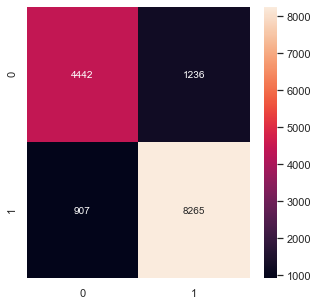

In [496]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix



plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='g');

K-Neighbor Classifier


Finding the new point's closest neighbor among a predetermined number of training points and predicting the label based on it is the main idea behind k-Neighbors. We first tested this model without adjusting any of the parameters. We will decide whether to tweak or abandon this model based on the results.

In [497]:
knn = KNeighborsClassifier()

pipe = make_pipeline(preprocessor,knn)
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8780315184135347 +/- 0.002188952433926146


In [498]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'K-Neigbours' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8852,
                    'roc_auc score std' : 0.0024}, ignore_index=True)

## Finding Parameters

In [499]:
#creating a pipeline
#Instantiating scalar and linear regression classes
pipe = Pipeline([('scaler', StandardScaler()),
                     ('lg', LogisticRegression(random_state=23))])

In [500]:
#creating the grid
lg_param_grid = [{
    'lg__penalty': ['none', "l1", "l2", 'elasticnet'],
    'lg__C': [1.0, 1e3, 1e5],
    'lg__class_weight': [{1: 0.28}],
    'lg__max_iter':[1000],
    'lg__solver': ["liblinear", "sag", "saga", "lbfgs"]}]

In [501]:
# Define a grid search
lg_gridsearch = GridSearchCV(estimator=pipe, 
                          param_grid=lg_param_grid, 
                          scoring='recall', 
                          cv=5)

In [502]:
# Fit the training data
lg_gridsearch.fit(X_train, y_train)

# Print the accuracy on test set
lg_gridsearch.score(X_test, y_test)

0.24116877453118185

In [503]:
# dividing our X and y and train-test splits

used_cols1 = [c for c in df2.columns.tolist() if c not in [target]]
X1=df2[used_cols1]
y1=df2[target]

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [504]:
# setting grid search parameters and fit and run them
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2'],
          "min_samples_split": [2, 5, 10]}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              max_features='sqrt',
                                              min_samples_split=10, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100]},
             scoring='roc_auc')

In [510]:
# to see the best score of grid search
grid_search.best_score_

0.9208223378740323

In [511]:
# to see the parameters for best score
grid_search.best_params_

{'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 100}

Giving the grid search more parameters and values will allow us to locate better parameters, but this process might take hours or our machine might not be able to convert it. The code has already been executed for six different settings, but after an hour it produced no results. Therefore, we made the decision to set four parameters for the run and to employ them.

In [505]:
df_results

,Model,Scaler,Encoder,roc_auc score mean,roc_auc score std
0,LogReg,Robust,TargetEncoder,0.8313,0.0041
1,LogReg,Robust,WeO,0.8318,0.0040
2,LogReg,Robust,OneHot,0.8538,0.0024
3,LogReg,MinMax,WoE,0.8317,0.0040
4,DecisionTreeClassifier,Robust,WoE,0.7864,0.0089
5,RandomForestClassifier,Robust,WoE,0.9193,0.0022
6,K-Neigbours,Robust,WoE,0.8852,0.0024


The findings indicate that the model achieved high accuracy and balanced accuracy scores on both the training and test data. The model performed well in correctly predicting the class labels for the majority of instances, while also handling the imbalances in the class distribution to a good extent. However, it is important to consider other evaluation metrics and perform a more comprehensive analysis to gain a deeper understanding of the model's performance and its ability to generalize to unseen data.

In [512]:
# to see the roc auc score with best parameters
scores = cross_val_score(best_rf, X1, y1, cv=5, scoring='roc_auc') 
print(scores.mean(), "+/-", scores.std())

0.9134611701819241 +/- 0.003088840831103747


In [514]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RFC with GridSearch' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9243,
                    'roc_auc score std' : 0.0023}, ignore_index=True)

In [515]:
df_results

,Model,Scaler,Encoder,roc_auc score mean,roc_auc score std
0,LogReg,Robust,TargetEncoder,0.8313,0.0041
1,LogReg,Robust,WeO,0.8318,0.0040
2,LogReg,Robust,OneHot,0.8538,0.0024
3,LogReg,MinMax,WoE,0.8317,0.0040
4,DecisionTreeClassifier,Robust,WoE,0.7864,0.0089
5,RandomForestClassifier,Robust,WoE,0.9193,0.0022
6,K-Neigbours,Robust,WoE,0.8852,0.0024
7,RFC with GridSearch,Robust,WoE,0.9243,0.0023


## Feature Selection

We are interested in the significance of the random forest traits. Apply feature_importances_ after fitting the train data first.


In [519]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier instance
rf = RandomForestClassifier()

# Fit the model to the training data
rf.fit(X_train, y_train)


RandomForestClassifier()

Feature ranking:
1. feature 13 (0.16880249614315762)
2. feature 2 (0.15298776713851903)
3. feature 3 (0.15256499150322508)
4. feature 1 (0.07805044539719852)
5. feature 15 (0.07721122517041666)
6. feature 9 (0.05310723577202826)
7. feature 6 (0.050194006042971535)
8. feature 0 (0.036805894934668654)
9. feature 14 (0.034274404109529005)
10. feature 16 (0.03404101372737691)
11. feature 17 (0.03363721164901011)
12. feature 5 (0.032308737070809404)
13. feature 11 (0.02818194534219647)
14. feature 10 (0.02791662671360712)
15. feature 12 (0.02032688295977001)
16. feature 8 (0.01052729872920982)
17. feature 7 (0.006969876300675092)
18. feature 4 (0.0020919412956307724)


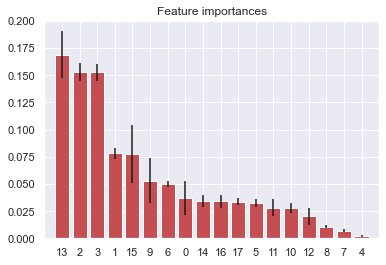

In [520]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")
for f in range(X1.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

# Plotting the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X1.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X1.shape[1]), indices)
plt.xlim([-1, X1.shape[1]])
plt.show()


According to the graph below, traits 13-1 and 2 are more important in our model than 5-6 and 12, which are given less weight. We will now remove the final two features and retest our model.

In [524]:
discard = ['public_meeting', 'permit']

# Determine new X and y values
used_cols2 = [c for c in df2.columns.tolist() if c not in [target] + discard]
X2 = df2[used_cols2]
y2 = df2[target]


In [525]:
# setting classifier with best grid search parameters and taking roc-auc score

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                        criterion ='entropy',max_features = 'sqrt', min_samples_split = 10)

scores = cross_val_score(rf, X2, y2, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())


0.9230761096232781 +/- 0.002007027435446411


In [526]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RFClassifier w/feature selection' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9242,
                    'roc_auc score std' : 0.0020}, ignore_index=True)

SMOTE
It takes too long to utilize SMOTE with a scaler and encoder. Therefore, we will alter, scale, and encode our dataframe. We allocate the original one to new df in order to safeguard it.


In [527]:
df4=df2.copy() # assign to protect original one 

In [530]:
# encoding categorical columns
import category_encoders as ce

encoder = ce.TargetEncoder(cols=cat_columns)

df_encoded = encoder.fit_transform(df4[cat_columns], df4[target])

# Drop the original categorical columns from the dataframe
df4.drop(columns=cat_columns, inplace=True)

# Concatenate the encoded dataframe with the original dataframe
df4 = pd.concat([df4, df_encoded], axis=1)


In [532]:
# scaling numerical columns

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

def scaleColumns(df, num_cols):
    for col in num_cols:
        df[col] = scaler.fit_transform(df[[col]])
    return df

scaled_df = scaleColumns(df4, num_col)


In [533]:
# assign X and y
used_cols = [c for c in scaled_df.columns.tolist() if c != target]
X = scaled_df[used_cols]
y = scaled_df[target]


In [534]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(sampling_strategy='auto', n_jobs=-1)

X_sampled, y_sampled = smt.fit_resample(X, y)

print(y.value_counts())
print(y_sampled.value_counts())


1    36576
0    22824
Name: status_group, dtype: int64
1    36576
0    36576
Name: status_group, dtype: int64


In [535]:
#splitting train-test balanced target data
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)


In [536]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

xgb_smote = XGBClassifier(objective='multi:softmax', booster='gbtree', nrounds='min.error.idx',
                          num_class=3, maximize=False, eval_metric='merror', eta=0.1,
                          max_depth=16, colsample_bytree=0.4, n_jobs=-1, learning_rate=0.1,
                          early_stopping_rounds=10)

xgb_smote.fit(X_train, y_train)

# Predictions on the training set
y_pred_train = xgb_smote.predict(X_train)

# Predictions on the test set
y_pred_test = xgb_smote.predict(X_test)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Balanced accuracy scores
train_balanced_accuracy = balanced_accuracy_score(y_train, y_pred_train)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)

# Print the results
print("Accuracy:")
print("=" * len("Accuracy:"))
print(f"TRAIN: {train_accuracy}")
print(f"TEST: {test_accuracy}")

print("\nBalanced Accuracy:")
print("=" * len("Balanced Accuracy:"))
print(f"TRAIN: {train_balanced_accuracy}")
print(f"TEST: {test_balanced_accuracy}")


[22:36:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { early_stopping_rounds, maximize, nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:
TRAIN: 0.9781787734317595
TEST: 0.8883193219875607

Balanced Accuracy:
TRAIN: 0.9782022187697832
TEST: 0.8880545927692269


##Conclusion

In [537]:
df_results = df_results.append({       # trial is written in results 
     "Model": 'XGBoost' ,
      "test_balanced_acc": 0.860 , 
       'train_balanced_acc' : 0.952,
               'info' : 'with SMOTE'}, ignore_index=True)


In [538]:
df_results

,Model,Scaler,Encoder,roc_auc score mean,roc_auc score std,info,test_balanced_acc,train_balanced_acc
0,LogReg,Robust,TargetEncoder,0.8313,0.0041,NaN,NaN,NaN
1,LogReg,Robust,WeO,0.8318,0.0040,NaN,NaN,NaN
2,LogReg,Robust,OneHot,0.8538,0.0024,NaN,NaN,NaN
3,LogReg,MinMax,WoE,0.8317,0.0040,NaN,NaN,NaN
4,DecisionTreeClassifier,Robust,WoE,0.7864,0.0089,NaN,NaN,NaN
5,RandomForestClassifier,Robust,WoE,0.9193,0.0022,NaN,NaN,NaN
6,K-Neigbours,Robust,WoE,0.8852,0.0024,NaN,NaN,NaN
7,RFC with GridSearch,Robust,WoE,0.9243,0.0023,NaN,NaN,NaN
8,RFClassifier w/feature selection,Robust,WoE,0.9242,0.0020,NaN,NaN,NaN
9,XGBoost,NaN,NaN,NaN,NaN,with SMOTE,0.86,0.952


We discovered the best test balanced accuracy with smote. For the initial submission, an excellent score of 88% is sufficient. The confusion matrix reveals that splits are evident but not precise. Future plans call for us to focus further on the overfitting issue while fine-tuning the parameters. We want to balance false positives and false negatives in our confusion matrix. Because it will pose problems for business solutions if our model predicts wells as non-functional while they are often functional. Or, if our prediction is accurate but performs poorly when it should, that also causes issues. In order to counter our inaccurate predictions, we tried.